In [1]:
# !pip install -q git+https://github.com/huggingface/transformers

In [8]:
import torch
import os
import io
import time
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from utils import *
%matplotlib inline
# Import sam vit pretrained model
from transformers import SamModel, SamProcessor

In [3]:
files_grabbed = []
files_info = []
path_check_include = ''

path_ign = os.getcwd() + '/data'
files_grabbed = glob.glob(os.path.join(path_ign, '*.jp2'))
files_info = glob.glob(os.path.join(path_ign, '*.tab'))
files_grabbed = [x for x in files_grabbed if path_check_include in x]
files_info = [x for x in files_info if path_check_include in x]

print("- nombre d'images:", len(files_grabbed), ', nb files info coord:', len(files_info))

- nombre d'images: 191 , nb files info coord: 191


In [4]:
def read_one(fname):
    img = cv2.imread(fname)      
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    return img
fname = files_grabbed[0]
print(fname)
ts = time.time()
img = read_one(fname)
print(time.time() - ts)

/home/coartix/S9-EPITA/ALEIA/General/PoolFinder/data/84-2018-0870-6310-LA93-0M50-IRC-E080.jp2
5.112312078475952


In [5]:
def split_image(img, nb_split):
    img_split = []
    h, w, c = img.shape
    for i in range(nb_split):
        for j in range(nb_split):
            img_split.append(img[i*h//nb_split:(i+1)*h//nb_split, j*w//nb_split:(j+1)*w//nb_split, :])
    return img_split

img_split = split_image(img, 16)
print(len(img_split))

256


Loading model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Device: cuda


/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:
img1 = img_split[0]
img1 = Image.fromarray(img1)

inputs = processor(img1, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

mask = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
)
scores = outputs.iou_scores

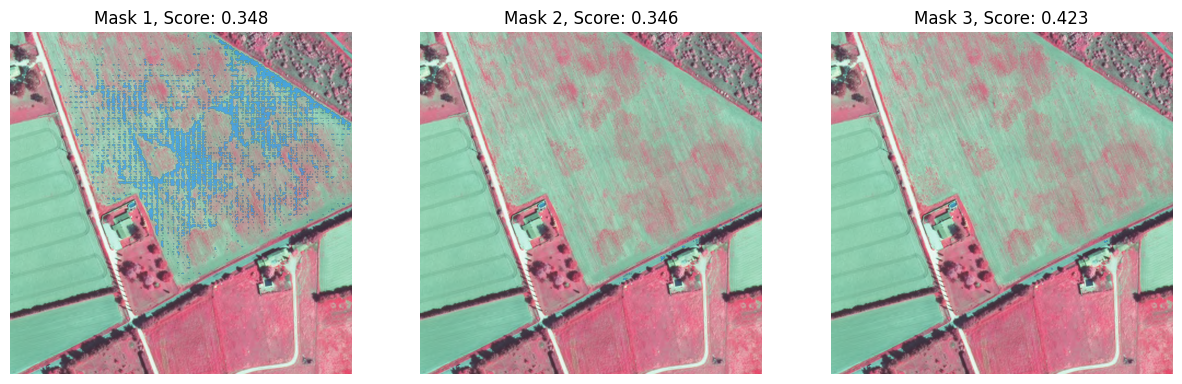

In [12]:
show_masks_on_image(img1, mask[0], scores)